<a href="https://colab.research.google.com/github/PabloCGarcia/bioDeepLearning/blob/main/demo_nf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  38900      0 --:--:-- --:--:-- --:--:-- 38900


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     |████████████████████████████████| 552kB 19.2MB/s 


'2.5.0.dev'

In [ ]:
!pip install selfies

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import deepchem as dc
from deepchem.models.normalizing_flows import NormalizingFlow, NormalizingFlowModel
from deepchem.models.optimizers import Adam
from deepchem.data import NumpyDataset
from deepchem.splits import RandomSplitter
from deepchem.molnet import load_tox21

import rdkit
from rdkit.Chem import Draw

from IPython.display import Image, display

import selfies as sf

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

tfk.backend.set_floatx('float64')

In [ ]:
tasks, datasets, transformers = dc.molnet.load_qm9(featurizer='ECFP')
df = pd.DataFrame(data={'smiles': datasets[0].ids})

In [ ]:
data = df[['smiles']].sample(2500, random_state=50)

In [ ]:
data.head()

,smiles
3670,[H]C1=C([H])C2(N([H])C(=O)N1[H])C([H])([H])C2(...
12694,[H]C([H])([H])OC12C([H])([H])C3(C([H])([H])[H]...
7790,[H]OC([H])([H])C([H])(O[H])C([H])([H])C([H])(C...
23035,[H]C#CC1([H])[NH+](C([H])([H])C([H])=O)C([H])(...
9969,[H]/N=C(/N(C([H])=O)C([H])([H])C([H])([H])[H])...


In [ ]:
sf.set_semantic_constraints()  # reset constraints
constraints = sf.get_semantic_constraints()
constraints['?'] = 3

sf.set_semantic_constraints(constraints)
constraints

{'?': 3,
 'Br': 1,
 'C': 4,
 'C+1': 5,
 'C-1': 3,
 'Cl': 1,
 'F': 1,
 'H': 1,
 'I': 1,
 'N': 3,
 'N+1': 4,
 'N-1': 2,
 'O': 2,
 'O+1': 3,
 'O-1': 1,
 'P': 7,
 'P+1': 8,
 'P-1': 6,
 'S': 6,
 'S+1': 7,
 'S-1': 5}

In [ ]:
def preprocess_smiles(smiles):
  return sf.encoder(smiles)  

data['selfies'] = data['smiles'].apply(preprocess_smiles)

In [ ]:
data.head()

,smiles,selfies
3670,[H]C1=C([H])C2(N([H])C(=O)N1[H])C([H])([H])C2(...,[Hexpl][C][=C][Branch1_1][C][Hexpl][C][Branch1...
12694,[H]C([H])([H])OC12C([H])([H])C3(C([H])([H])[H]...,[Hexpl][C][Branch1_1][C][Hexpl][Branch1_1][C][...
7790,[H]OC([H])([H])C([H])(O[H])C([H])([H])C([H])(C...,[Hexpl][O][C][Branch1_1][C][Hexpl][Branch1_1][...
23035,[H]C#CC1([H])[NH+](C([H])([H])C([H])=O)C([H])(...,[Hexpl][C][#C][C][Branch1_1][C][Hexpl][NH+expl...
9969,[H]/N=C(/N(C([H])=O)C([H])([H])C([H])([H])[H])...,[Hexpl][/N][=C][Branch2_1][Ring1][Branch2_1][/...


In [ ]:
data['len'] = data['smiles'].apply(lambda x: len(x))
data.sort_values(by='len').head()

,smiles,selfies,len
42125,N#CC#CC#CC#N,[N][#C][C][#C][C][#C][C][#N],12
71623,O=c1nc(F)nno1,[O][=C][N][=C][Branch1_1][C][F][N][=N][O][Ring...,13
38660,[H]N([H])c1nnon1,[Hexpl][N][Branch1_1][C][Hexpl][C][N][=N][O][N...,16
1194,[H]n1nnc(C#N)nc1=O,[Hexpl][N][N][=N][C][Branch1_1][Ring1][C][#N][...,18
80720,N=N.[H]N=CNC(=O)C#N,[N][=N].[Hexpl][N][=C][N][C][Branch1_2][C][=O]...,19


In [ ]:
filtro = data[data["selfies"].str.contains("\.") ].index
data.drop(index=filtro, inplace=True)

In [ ]:
selfies_list=data.selfies.to_list()

In [ ]:
#selfies_list = np.asanyarray(data.selfies)
selfies_alphabet = sf.get_alphabet_from_selfies(selfies_list)
selfies_alphabet.add('[nop]')  # Add the "no operation" symbol as a padding character
#i=0
#while len(selfies_alphabet)!=65:
#    i+=1
#    selfies_alphabet.add('[nop' + str(i)+']')
selfies_alphabet = list(sorted(selfies_alphabet))
symbol_to_idx = {s: i for i, s in enumerate(selfies_alphabet)}
largest_selfie_len = max(sf.len_selfies(s) for s in selfies_list)

In [ ]:
idx_to_symbol = {i: s for i, s in enumerate(selfies_alphabet)}

In [ ]:
#def selfies_to_hot(selfie, largest_selfie_len, alphabet):
#    """Go from a single selfies string to a one-hot encoding.
#    """
#    #print(selfie)
#    symbol_to_int = dict((c, i) for i, c in enumerate(alphabet))
#
#    # pad with [nop]
#    selfie += '[nop]' * (largest_selfie_len - sf.len_selfies(selfie))
#
#    # integer encode
#    symbol_list = sf.split_selfies(selfie)
#    integer_encoded = [symbol_to_int[symbol] for symbol in symbol_list]
#
#    # one hot-encode the integer encoded selfie
#    onehot_encoded = list()
#    for index in integer_encoded:
#        letter = [0] * len(alphabet)
#        letter[index] = 1
#        onehot_encoded.append(letter)
#
#    return integer_encoded, np.array(onehot_encoded)
#
#
#def multiple_selfies_to_hot(selfies_list, largest_molecule_len, alphabet):
#    """Convert a list of selfies strings to a one-hot encoding
#    """
#
#    hot_list = []
#    for s in selfies_list:
#        _, onehot_encoded = selfies_to_hot(s, largest_molecule_len, alphabet)
#        hot_list.append(onehot_encoded)
#    return np.array(hot_list)

In [ ]:
selfies_alphabet

['[#C]',
 '[#N]',
 '[/C]',
 '[/Hexpl]',
 '[/N]',
 '[/O]',
 '[=C]',
 '[=N+expl]',
 '[=N]',
 '[=O]',
 '[Branch1_1]',
 '[Branch1_2]',
 '[Branch1_3]',
 '[Branch2_1]',
 '[Branch2_2]',
 '[Branch2_3]',
 '[C+expl]',
 '[C-expl]',
 '[CH+expl]',
 '[C]',
 '[Expl=Ring1]',
 '[Expl=Ring2]',
 '[Expl\\Ring2]',
 '[F]',
 '[Hexpl]',
 '[N+expl]',
 '[N-expl]',
 '[NH+expl]',
 '[NH2+expl]',
 '[NHexpl]',
 '[N]',
 '[O-expl]',
 '[O]',
 '[P]',
 '[Ring1]',
 '[Ring2]',
 '[S]',
 '[\\C-expl]',
 '[\\C]',
 '[\\Hexpl]',
 '[\\N]',
 '[nop]']

In [ ]:
onehots = sf.batch_selfies_to_flat_hot(  selfies_list, symbol_to_idx, largest_selfie_len)

In [ ]:
largest_selfie_len

62

In [ ]:
len(selfies_alphabet)

42

In [ ]:
input_tensor = tf.convert_to_tensor(onehots, dtype='float64')
noise_tensor = tf.random.uniform(shape=input_tensor.shape, minval=0, maxval=1, dtype='float64')
dequantized_data = tf.add(input_tensor, noise_tensor)

In [ ]:
ds = NumpyDataset(dequantized_data)  # Create a DeepChem dataset
splitter = RandomSplitter()
train, val, test = splitter.train_valid_test_split(dataset=ds, seed=42)
train_idx, val_idx, test_idx = splitter.split(dataset=ds, seed=42)

dim = len(train.X[0])  # length of one-hot encoded vectors
train.X.shape  # 2000 samples, N-dimensional one-hot vectors that represent molecules

(1996, 2604)

In [ ]:
# SMILES strings of training data
train_smiles = data['smiles'].iloc[train_idx].values

In [ ]:
base_dist = tfd.MultivariateNormalDiag(loc=np.zeros(dim), scale_diag=np.ones(dim))

if dim % 2 == 0:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2, dim), np.arange(0, dim / 2))),
                                  tf.int32)
else:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2 + 1, dim), np.arange(0, dim / 2))), tf.int32)

In [ ]:
dim

2604

In [ ]:
num_layers = 8
flow_layers = []

Made = tfb.AutoregressiveNetwork(params=2,
                                 hidden_units=[512, 512], activation='relu')

for i in range(num_layers):
    flow_layers.append(        
        (tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=Made)
    ))

    permutation = tf.cast(np.random.permutation(np.arange(0, dim)), tf.int32)
    
    flow_layers.append(tfb.Permute(permutation=permutation))
    
#     if (i + 1) % int(2) == 0:
#         flow_layers.append(tfb.BatchNormalization())

In [ ]:
%%time
nf = NormalizingFlow(base_distribution=base_dist,
                    flow_layers=flow_layers)
samples = nf.flow.sample(5)

CPU times: user 1min 30s, sys: 2.12 s, total: 1min 32s
Wall time: 1min 34s


In [ ]:
nfm = NormalizingFlowModel(nf, learning_rate=1e-4, batch_size=128)

In [ ]:
losses = []
val_losses = []

In [ ]:
%%time
max_epochs = 20 # maximum number of epochs of the training

for epoch in range(max_epochs):
  print("Epoca:", epoch)
  loss = nfm.fit(train, nb_epoch=1, all_losses=losses)
  val_loss = nfm.create_nll(val.X)
  val_losses.append(val_loss.numpy())

Epoca: 0
Epoca: 1
Epoca: 2
Epoca: 3
Epoca: 4
Epoca: 5
Epoca: 6
Epoca: 7
Epoca: 8
Epoca: 9
Epoca: 10
Epoca: 11
Epoca: 12
Epoca: 13
Epoca: 14
Epoca: 15
Epoca: 16
Epoca: 17
Epoca: 18
Epoca: 19
CPU times: user 27.9 s, sys: 7.75 s, total: 35.7 s
Wall time: 1min 49s


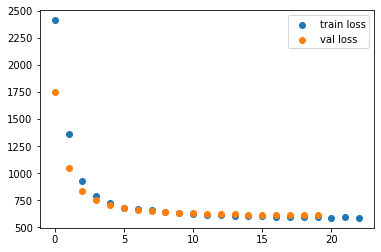

In [ ]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

In [ ]:
generated_samples = nfm.flow.sample(5)  # generative modeling
log_probs = nfm.flow.log_prob(generated_samples)  # probability density estimation

In [ ]:
mols = tf.math.floor(generated_samples)  # quantize data
mols = tf.clip_by_value(mols, 0, 1)  # Set negative values to 0 and values > 1 to 1
mols_list = mols.numpy().tolist()

# Add padding characters if needed
for mol in mols_list:
  for i in range(largest_selfie_len):
    row = mol[len(selfies_alphabet) * i: len(selfies_alphabet) * (i + 1)]
    if all(elem == 0 for elem in row):
      try:
        mol[len(selfies_alphabet) * (i+1) - 1] = 1
      except:
        #print("descarto los nopx que había agregado")
        pass

In [ ]:
mols = sf.batch_flat_hot_to_selfies(mols_list, selfies_alphabet)

In [ ]:
mols_list[1]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [ ]:
mols[1]

'[CH+expl][/Hexpl][#C][=N][CH+expl][/C][Branch1_1][nop][/C][#N][=O][Branch1_1][Branch1_3][Branch1_2][nop][Branch1_1][/Hexpl][#C][Branch2_2][C][Branch1_1][nop][#C][/N][=O][Branch2_1][Branch1_1][nop][C][=C][C+expl][=N][=C][Branch1_3][C-expl][C-expl][Branch1_1][/O][Ring1][Branch2_1][/Hexpl][#N][NH+expl][/O][/O][F][#N][nop][=C][Ring1][/C][#N][Ring1][#C][nop][=N+expl][CH+expl][nop][/C][nop][NH+expl][\\C-expl]'

In [ ]:
from rdkit import RDLogger  
from rdkit import Chem
RDLogger.DisableLog('rdApp.*')  # suppress error messages

valid_count = 0
valid_selfies, invalid_selfies = [], []
for idx, selfies in enumerate(mols):
  try:
    if Chem.MolFromSmiles(sf.decoder(mols[idx]), sanitize=True) is not None:
        valid_count += 1
        valid_selfies.append(selfies)
    else:
      invalid_selfies.append(selfies)
  except Exception:
    pass
print('%.2f' % (valid_count / len(mols)),  '% of generated samples are valid molecules.')

1.00 % of generated samples are valid molecules.


In [ ]:
gen_mols = [Chem.MolFromSmiles(sf.decoder(vs)) for vs in valid_selfies]

In [ ]:
gen_mols

In [ ]:

def display_images(filenames):
    """Helper to pretty-print images."""
    for file in filenames:
      display(Image(file))

def mols_to_pngs(mols, basename="generated_mol"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

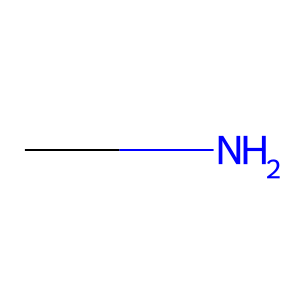

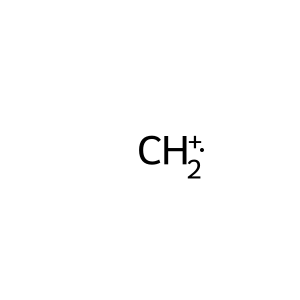

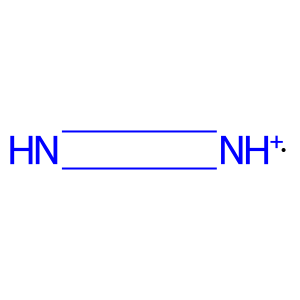

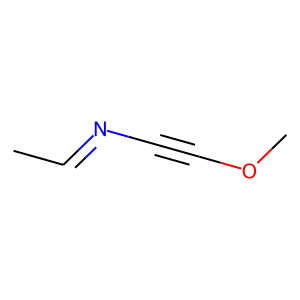

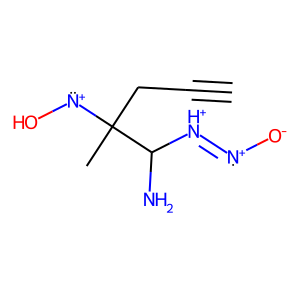

In [ ]:

display_mols = []
for i in range(5):
  display_mols.append(gen_mols[i])

display_images(mols_to_pngs(display_mols))

In [ ]:
from rdkit.Chem.Fingerprints.FingerprintMols import FingerprintMol
from rdkit.DataStructs import FingerprintSimilarity
from IPython.display import display

def tanimoto_similarity(database_mols, query_mol):
    """Compare generated molecules to database by Tanimoto similarity."""
    # convert Mol to datastructure type
    fps = [FingerprintMol(m) for m in database_mols]
    
    # set a query molecule to compare against database
    query = FingerprintMol(query_mol)
    
    similarities = []
    
    # loop through to find Tanimoto similarity
    for idx, f in enumerate(fps):
        # tuple: (idx, similarity)
        similarities.append((idx, FingerprintSimilarity(query, f)))
    
    # sort sim using the similarities
    similarities.sort(key=lambda x:x[1], reverse=True)
    
    return similarities

In [ ]:
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]

In [ ]:
# change the second argument to compare different generated molecules to QM9
tanimoto_scores = tanimoto_similarity(train_mols, gen_mols[3])
similar_mols = []

0.545
0.537
0.533


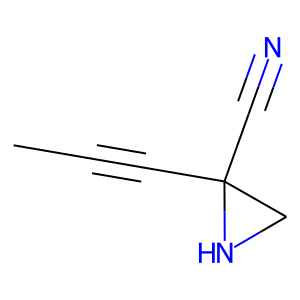

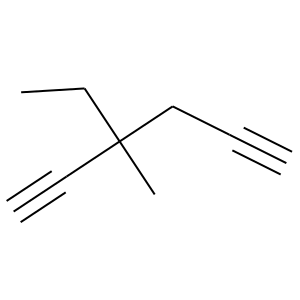

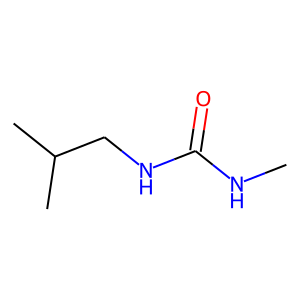

In [ ]:
for idx, ts in tanimoto_scores[:3]:
    print(round(ts, 3))
    similar_mols.append(train_mols[idx])

display_images(mols_to_pngs(similar_mols, 'qm9_mol'))